In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *
# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

alphapose_root, motionbert_root, kookmin_root, ap_kookmin_result_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AssertionError: Kookmin root directory is not exist

#### Load H36M Dataset

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [3]:
os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone
from lib.model.loss import *
from lib.data.datareader_kookmin import DataReaderKOOKMIN
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.dataset_motion_3d import MotionDataset3D
from lib.model.DHDSTformer import DHDSTformer, DHDSTformer2, DHDSTformer3, DHDSTformer_limb, DHDSTformer_torso

def parse_args(target):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/DHDST_kookmin_baseline.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    opts = parser.parse_args([
        '--config', 'configs/pose3d/{}.yaml'.format(target),
        '--evaluate', 'checkpoint/pose3d/{}/best_epoch.bin'.format(target)])
    return opts

target = 'MB_ft_h36m'
# target = 'DHDST2_kookmin_baseline'
# target = 'DHDST_limb_h36m_baseline'
# target = 'DHDST_torso_h36m_baseline'
# target = 'DHDST_torso_h36m_lower1_upper1'

# lower_upper_loss = False
# lambda_lower = 0
# lambda_upper = 0
# if lower_upper_loss:
#     if lambda_lower == 0.0:
#         target = 'DHDST_torso_h36m_upper{}'.format(lambda_upper)
#     elif lambda_upper == 0.0:
#         target = 'DHDST_torso_h36m_lower{}'.format(lambda_lower)
#     else:
#         target = 'DHDST_torso_h36m_lower{}_upper{}'.format(lambda_lower, lambda_upper)
# else:
#     target = 'DHDST_torso_h36m_baseline'

opts = parse_args(target=target)
args = get_config(opts.config)
print(opts.evaluate)

if 'DHDST2' in opts.evaluate:
    model_pos = DHDSTformer2(chk_filename='', args=args)
elif 'DHDST_torso' in opts.evaluate:
    model_pos = DHDSTformer_torso(chk_filename='', args=args)
elif 'DHDST_limb' in opts.evaluate:
    model_pos = DHDSTformer_limb(chk_filename='', args=args)
elif 'MB' in opts.evaluate:
    model_pos = load_backbone(args)
    
model_pos = nn.DataParallel(model_pos)
model_pos = model_pos.cuda()
checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
model_pos.eval()

checkpoint/pose3d/MB_ft_h36m/best_epoch.bin


DataParallel(
  (module): DSTformer(
    (joints_embed): Linear(in_features=3, out_features=512, bias=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks_st): ModuleList(
      (0): Block(
        (norm1_s): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (norm1_t): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (attn_s): Attention(
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (attn_t): Attention(
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (qkv): Linear(in_features=512, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2_s): LayerNorm((512,), eps=1e-06,

In [4]:
args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'
args.subset_list = ['H36M-SH']
datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
test_loader = DataLoader(test_dataset, **testloader_params)


In [9]:
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader):
        if torch.cuda.is_available():
            batch_input = batch_input.cuda()
            batch_gt = batch_gt.cuda()
        batch_input_denormalized = datareader.denormalize(batch_input.cpu().detach().numpy())
        batch_input -= batch_input[:, :, 0].unsqueeze(2).repeat(1, 1, 17, 1) # root-relative
        batch_height = batch_input[:, :, :, 1].max(dim=-1).values - batch_input[:, :, :, 1].min(dim=-1).values
        batch_ratio = torch.ones_like(batch_height) / batch_height
        batch_input = batch_input * batch_ratio.unsqueeze(-1).unsqueeze(-1)
        batch_input_denormalized_with_canonical = datareader.denormalize(batch_input.cpu().detach().numpy())
        break

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]


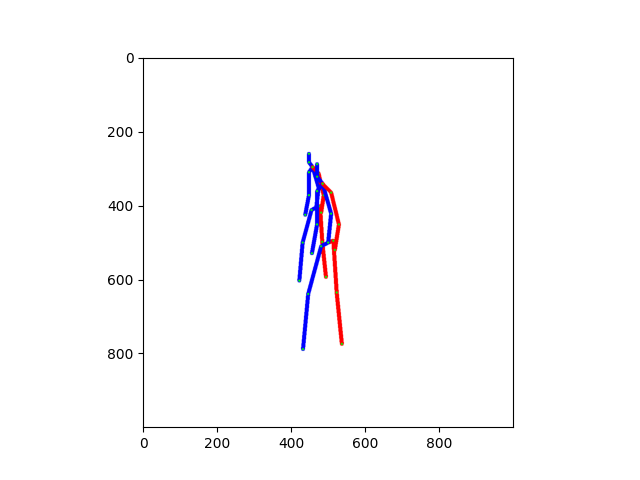

In [12]:
fig = plt.figure(0)
fig.clear()
ax = fig.add_subplot(111)
img = get_2d_pose_image(batch_input_denormalized[0, 50], W=1000, H=1000)
img = get_2d_pose_image(batch_input_denormalized_with_canonical[0, 50], img=img, W=1000, H=1000)
ax.imshow(img)
plt.show()

In [13]:
batch_input_denormalized.shape

(16, 243, 17, 3)

In [16]:
batch_num = -1
videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/Canonical/canonical_test{}.mp4'.format(batch_num), fps=30)
for i in range(243):
    img = get_2d_pose_image(batch_input_denormalized_with_canonical[batch_num, i], W=1000, H=1000)
    cv2.putText(img, str(i), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
    videowriter.append_data(img)
videowriter.close()

videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/Canonical/test{}.mp4'.format(batch_num), fps=30)
for i in range(243):
    img = get_2d_pose_image(batch_input_denormalized[batch_num, i], W=1000, H=1000)
    cv2.putText(img, str(i), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
    videowriter.append_data(img)
videowriter.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x617cdc0] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73addc0] Warning: data is not aligned! This can lead to a speed loss
